##### Copyright 2018 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/swift/tutorials/model_training_walkthrough"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/swift/blob/master/docs/site/tutorials/model_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/swift/blob/master/docs/site/tutorials/model_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Model training walkthrough

This guide introduces Swift for TensorFlow by building a machine learning model that categorizes iris flowers by species. It uses Swift for TensorFlow to:
1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.

## TensorFlow programming

This guide uses these high-level Swift for TensorFlow concepts:

* Import data with the Datasets API.
* Build models using Swift abstractions.
* Use Python libraries using Swift's Python interoperability when pure Swift libraries are not available.

This tutorial is structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

## Setup program

### Configure imports

Import TensorFlow and some useful Python modules.

In [1]:
import TensorFlow

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

// Download a helper file that helps us work around some temporary limitations
// in the dataset API.
let path = Python.import("os.path")
let urllib = Python.import("urllib.request")
let helperFiles = ["TutorialDatasetCSVAPI.swift"]
let helperFileBaseURL = "https://raw.githubusercontent.com/tensorflow/swift/master/docs/site/tutorials/"
for helperFile in helperFiles {
    if !Bool(path.isfile(helperFile))! {
        print("Downloading \(helperFile)")
        urllib.urlretrieve(helperFileBaseURL + helperFile, filename: helperFile)
    } else {
        print("Not downloading \(helperFile): already exists")
    }
}

Not downloading TutorialDatasetCSVAPI.swift: already exists


## The iris classification problem

Imagine you are a botanist seeking an automated way to categorize each iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify iris flowers based on the length and width measurements of their [sepals](https://en.wikipedia.org/wiki/Sepal) and [petals](https://en.wikipedia.org/wiki/Petal).

The Iris genus entails about 300 species, but our program will only classify the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Fortunately, someone has already created a [data set of 120 iris flowers](https://en.wikipedia.org/wiki/Iris_flower_data_set) with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

## Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Swift program.

### Download the dataset

Download the training dataset file from http://download.tensorflow.org/data/iris_training.csv. We use a Python library to demonstrate Swift's Python interoperability. Swift's Python interoperability makes it easy and natural to import and use Python libraries from Swift code.

In [2]:
let urllib = Python.import("urllib.request")
let downloadResult = urllib.urlretrieve(
    "http://download.tensorflow.org/data/iris_training.csv",
    "iris_training.csv")
let trainDataFilename = String(downloadResult[0])!
trainDataFilename

"iris_training.csv"


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Let's look a the first 5 entries.

In [3]:
let f = Python.open(trainDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


None


From this view of the dataset, notice the following:

1. The first line is a header containing information about the dataset:
  * There are 120 total examples. Each example has four features and one of three possible label names. 
2. Subsequent rows are data records, one *[example](https://developers.google.com/machine-learning/glossary/#example)* per line, where:
  * The first four fields are *[features](https://developers.google.com/machine-learning/glossary/#feature)*: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
  * The last column is the *[label](https://developers.google.com/machine-learning/glossary/#label)*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Let's write that out in code:

In [4]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

For more information about features and labels, see the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [5]:
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

### Create a Dataset

Swift for TensorFlow's Dataset API is a high-level API for reading data and transforming it into a form used for training.

Eventually, the Dataset API will be able to load data from many file formats. The Dataset API is currently very incomplete, so we include some glue code from "TutorialDatasetCSVAPI.swift" that helps the Dataset API load data from the CSV file into the `IrisBatch` struct.

In [6]:
let batchSize = 32

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

%include "TutorialDatasetCSVAPI.swift"

let trainDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: trainDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

The `Dataset<IrisBatch>` is a sequence of `IrisBatch`es. Let's look at the first element of the dataset.

In [7]:
let firstTrainExamples = trainDataset.first!
let firstTrainFeatures = firstTrainExamples.features
let firstTrainLabels = firstTrainExamples.labels
print("First batch of features: \(firstTrainFeatures)")
print("First batch of labels: \(firstTrainLabels)")

First batch of features: [[6.4, 2.8, 5.6, 2.2],
 [5.0, 2.3, 3.3, 1.0],
 [4.9, 2.5, 4.5, 1.7],
 [4.9, 3.1, 1.5, 0.1],
 [5.7, 3.8, 1.7, 0.3],
 [4.4, 3.2, 1.3, 0.2],
 [5.4, 3.4, 1.5, 0.4],
 [6.9, 3.1, 5.1, 2.3],
 [6.7, 3.1, 4.4, 1.4],
 [5.1, 3.7, 1.5, 0.4],
 [5.2, 2.7, 3.9, 1.4],
 [6.9, 3.1, 4.9, 1.5],
 [5.8, 4.0, 1.2, 0.2],
 [5.4, 3.9, 1.7, 0.4],
 [7.7, 3.8, 6.7, 2.2],
 [6.3, 3.3, 4.7, 1.6],
 [6.8, 3.2, 5.9, 2.3],
 [7.6, 3.0, 6.6, 2.1],
 [6.4, 3.2, 5.3, 2.3],
 [5.7, 4.4, 1.5, 0.4],
 [6.7, 3.3, 5.7, 2.1],
 [6.4, 2.8, 5.6, 2.1],
 [5.4, 3.9, 1.3, 0.4],
 [6.1, 2.6, 5.6, 1.4],
 [7.2, 3.0, 5.8, 1.6],
 [5.2, 3.5, 1.5, 0.2],
 [5.8, 2.6, 4.0, 1.2],
 [5.9, 3.0, 5.1, 1.8],
 [5.4, 3.0, 4.5, 1.5],
 [6.7, 3.0, 5.0, 1.7],
 [6.3, 2.3, 4.4, 1.3],
 [5.1, 2.5, 3.0, 1.1]]
First batch of labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


Notice that the features for the first `batchSize` examples are grouped together (or *batched*) into `firstTrainFeatures`, and that the labels for the first `batchSize` examples are batched into `firstTrainLabels`.

You can start to see some clusters by plotting a few features from the batch, using Python's matplotlib:

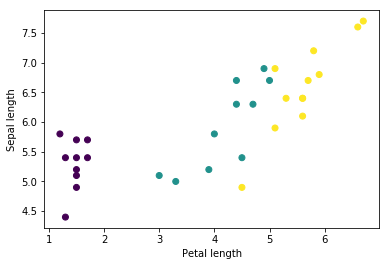

None


In [8]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[2].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

## Select the type of model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  For the iris classification problem, the model defines the relationship between the sepal and petal measurements and the predicted iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the iris species *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between petal and sepal measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

We need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the iris classification problem. *[Neural networks](https://developers.google.com/machine-learning/glossary/#neural_network)* can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more *[hidden layers](https://developers.google.com/machine-learning/glossary/#hidden_layer)*. Each hidden layer consists of one or more *[neurons](https://developers.google.com/machine-learning/glossary/#neuron)*. There are several categories of neural networks and this program uses a dense, or *[fully-connected neural network](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*: the neurons in one layer receive input connections from *every* neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given iris species. This prediction is called *[inference](https://developers.google.com/machine-learning/crash-course/glossary#inference)*. For this example, the sum of the output predictions is 1.0. In Figure 2, this prediction breaks down as: `0.02` for *Iris setosa*, `0.95` for *Iris versicolor*, and `0.03` for *Iris virginica*. This means that the model predicts—with 95% probability—that an unlabeled example flower is an *Iris versicolor*.

### Create a model using the Swift for TensorFlow Deep Learning Library

The [Swift for TensorFlow Deep Learning Library](https://github.com/tensorflow/swift-apis) defines primitive layers and conventions for wiring them together, which makes it easy to build models and experiment.

A model is a `struct` that conforms to [`Layer`](https://www.tensorflow.org/swift/api_docs/Protocols/Layer), which means that it defines an `applied(to:in:)` method that maps input `Tensor`s to output `Tensor`s. The `applied(to:in:)` method often simply sequences the input through sublayers. Let's define an `IrisModel` that sequences the input through three [`Dense`](https://www.tensorflow.org/swift/api_docs/Structs/Dense) sublayers.

In [9]:
import TensorFlow

let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func applied(to input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

The activation function determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many available activations, but [ReLU](https://www.tensorflow.org/swift/api_docs/Functions#/s:10TensorFlow4reluyAA0A0VyxGAESFRzAA0aB6ScalarRzlF) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

### Using the model

Let's have a quick look at what this model does to a batch of features:

In [10]:
// Apply the model to a batch of features.
let firstTrainPredictions = model.applied(to: firstTrainFeatures)
firstTrainPredictions[0..<5]

[[  1.4039098,  0.14866072,   -0.551167],
 [ 0.93209726, 0.025419176, -0.30919415],
 [  1.1386487,  0.24533069,  -0.4815638],
 [  0.7907541,  0.24558473, -0.37229377],
 [ 0.96132296,   0.3498453, -0.46737808]]


Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class. 

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [11]:
softmax(firstTrainPredictions[0..<5])

[[0.70098776, 0.19978492, 0.09922735],
 [ 0.5907113,  0.2385668, 0.17072192],
 [0.62221867, 0.25467128, 0.12311009],
 [ 0.5284642, 0.30637375, 0.16516207],
 [ 0.5611142, 0.30443168, 0.13445416]]


Taking the `argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [12]:
print("Prediction: \(firstTrainPredictions.argmax(squeezingAxis: 1))")
print("    Labels: \(firstTrainLabels)")

Prediction: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


## Train the model

*[Training](https://developers.google.com/machine-learning/crash-course/glossary#training)* is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called *[overfitting](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)*—it's like memorizing the answers instead of understanding how to solve a problem.

The iris classification problem is an example of *[supervised machine learning](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*: the model is trained from examples that contain labels. In *[unsupervised machine learning](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*, the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Choose a loss function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [`softmaxCrossEntropy(logits:labels:)`](https://www.tensorflow.org/swift/api_docs/Functions#/s:10TensorFlow19softmaxCrossEntropy6logits6labelsAA0A0VyxGAG_AFys5Int32VGtAA0aB13FloatingPointRzlF) function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

Let's calculate the loss for the current untrained model:

In [13]:
let untrainedLogits = model.applied(to: firstTrainFeatures)
let untrainedLoss = softmaxCrossEntropy(logits: untrainedLogits, labels: firstTrainLabels)
print("Loss test: \(untrainedLoss)")

Loss test: 1.5416216


### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

Swift for TensorFlow has many [optimization algorithms](https://github.com/rxwei/DeepLearning/blob/master/Sources/DeepLearning/Optimizer.swift) available for training. This model uses the SGD optimizer that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learningRate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

In [14]:
let optimizer = SGD(for: model, learningRate: 0.01)

Let's use `optimizer` to take a single gradient descent step. First, we compute the gradient of the loss with respect to the model:

In [15]:
let (loss, grads) = model.valueWithGradient { model -> Tensor<Float> in
    let logits = model.applied(to: firstTrainFeatures)
    return softmaxCrossEntropy(logits: logits, labels: firstTrainLabels)
}
print("Current loss: \(loss)")

Current loss: 1.5416216


Next, we pass the gradient that we just calculated to the optimizer, which updates the model's differentiable variables accordingly:

In [16]:
optimizer.update(&model.allDifferentiableVariables, along: grads)

If we calculate the loss again, it should be smaller, because gradient descent steps (usually) decrease the loss:

In [17]:
let logitsAfterOneStep = model.applied(to: firstTrainFeatures)
let lossAfterOneStep = softmaxCrossEntropy(logits: logitsAfterOneStep, labels: firstTrainLabels)
print("Next loss: \(lossAfterOneStep)")

Next loss: 1.4473524


### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use gradient descent to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `epochCount` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `epochCount` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

In [18]:
let epochCount = 500
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [19]:
func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batch in trainDataset {
        let (loss, grad) = model.valueWithGradient { (model: IrisModel) -> Tensor<Float> in
            let logits = model.applied(to: batch.features)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model.allDifferentiableVariables, along: grad)
        
        let logits = model.applied(to: batch.features)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epoch % 50 == 0 {
        print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 50: Loss: 0.49441946, Accuracy: 0.8151042
Epoch 100: Loss: 0.34787804, Accuracy: 0.9453125
Epoch 150: Loss: 0.26503962, Accuracy: 0.96875
Epoch 200: Loss: 0.2040326, Accuracy: 0.96875
Epoch 250: Loss: 0.16448447, Accuracy: 0.9765625
Epoch 300: Loss: 0.13938247, Accuracy: 0.9765625
Epoch 350: Loss: 0.12293156, Accuracy: 0.9765625
Epoch 400: Loss: 0.11160723, Accuracy: 0.9765625
Epoch 450: Loss: 0.103580505, Accuracy: 0.9765625
Epoch 500: Loss: 0.097624585, Accuracy: 0.984375


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. We can create basic charts using Python's `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

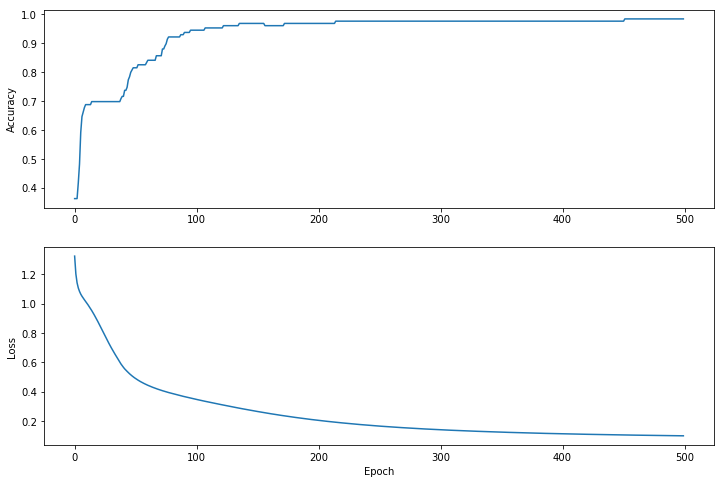

None


In [20]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()

Note that the y-axes of the graphs are not zero-based.

## Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at iris classification, pass some sepal and petal measurements to the model and ask the model to predict what iris species they represent. Then compare the model's prediction against the actual label.  For example, a model that picked the correct species on half the input examples has an *[accuracy](https://developers.google.com/machine-learning/glossary/#accuracy)* of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> An iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the test set from http://download.tensorflow.org/data/iris_training.csv:

In [21]:
let urllib = Python.import("urllib.request")
let downloadResult = urllib.urlretrieve(
    "http://download.tensorflow.org/data/iris_test.csv",
    "iris_test.csv")
let testDataFilename = String(downloadResult[0])!
testDataFilename

"iris_test.csv"


 Now load it into a `Dataset`:

In [22]:
let testDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: testDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [23]:
// NOTE: With `batchSize = 32` and 30 examples in the test dataset, only one batch will run in the loop.
for testBatch in testDataset {
    let logits = model.applied(to: testBatch.features)
    let predictions = logits.argmax(squeezingAxis: 1)
    print("Test batch accuracy: \(accuracy(predictions: predictions, truths: testBatch.labels))")
}

Test batch accuracy: 0.93333334


We can see on the first batch, for example, the model is usually correct:

In [24]:
let firstTestBatch = testDataset.first!
let firstTestBatchLogits = model.applied(to: firstTestBatch.features)
let firstTestBatchPredictions = firstTestBatchLogits.argmax(squeezingAxis: 1)

print(firstTestBatchPredictions)
print(firstTestBatch.labels)

[1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1]
[1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]


## Use the trained model to make predictions

We've trained a model and demonstrated that it's good—but not perfect—at classifying iris species. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [25]:
let unlabeledDataset: Tensor<Float> =
    [[5.1, 3.3, 1.7, 0.5],
     [5.9, 3.0, 4.2, 1.5],
     [6.9, 3.1, 5.4, 2.1]]

let unlabeledDatasetPredictions = model.applied(to: unlabeledDataset)

for i in 0..<unlabeledDatasetPredictions.shape[0] {
    let logits = unlabeledDatasetPredictions[i]
    let classIdx = logits.argmax().scalar!
    print("Example \(i) prediction: \(classNames[Int(classIdx)]) (\(softmax(logits)))")
}

Example 0 prediction: Iris setosa ([   0.99680245,  0.0031974867, 1.4739053e-09])
Example 1 prediction: Iris versicolor ([0.0010103396,   0.99005497,  0.008934729])
Example 2 prediction: Iris virginica ([0.00012091544,    0.18576133,     0.8141177])
